# DIABETES PREDICTION MODEL

# CLASSIFICATION MODELS - CROSS VALIDATION

'''
Steps to follow:
    - Load the saved dataset
    - General View
    - Modeling
        - Base models: LogisticRegression, GaussianNB, KNeighborsClassifier, SVC, MLPClassifier, DecisionTreeClassifier,
                       BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,
                       XGBClassifier, LGBMClassifier, CatBoostClassifier, NGBClassifier
    - Model Evaluation
    - Model Tuning
    - Model Results
'''

In [8]:


# Import dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from ngboost import NGBClassifier

import os
import pickle

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassPredictionError

import warnings
warnings.simplefilter(action="ignore")
pd.pandas.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [9]:
# Load the preprocessed dataset
diabetes_preprocessed = pd.read_csv(r'diabetes_prepared.csv')
df = diabetes_preprocessed.copy()

In [10]:
## GENERAL VIEW

df.head()
df.shape
df.info()
df.columns
df.index
df.describe([0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]).T

# Check for missing values
df.isnull().values.any()
df.isnull().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
 9   Pregnancies/Age           768 non-null    float64
 10  BMIRanges_Obese           768 non-null    int64  
 11  BMIRanges_Overweight      768 non-null    int64  
 12  BMIRanges_Underweight     768 non-null    int64  
 13  AgeRanges_Senior          768 non-null    int64  
 14  AgeRanges_

Pregnancies                 0
Glucose                     0
GlucoseLevels_Normal        0
GlucoseLevels_Low           0
AgeRanges_Young             0
AgeRanges_Senior            0
BMIRanges_Underweight       0
BMIRanges_Overweight        0
BMIRanges_Obese             0
Pregnancies/Age             0
Outcome                     0
Age                         0
DiabetesPedigreeFunction    0
BMI                         0
Insulin                     0
SkinThickness               0
BloodPressure               0
GlucoseLevels_Secret        0
dtype: int64

In [11]:
# MODELING

# Define dependent and independent variables
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

In [12]:
# Evaluate each model in turn by looking at cross validation scores
def evaluate_classification_model_cross_validation(models, X, y):
    # Define lists to track names and results for models
    names = []
    train_accuracy_results = []
    cross_validation_scores = []

    print('################ Accuracy scores (cross-validation=10) for test set for the models: ################\n')
    for name, model in models:
        model.fit(X, y)
        y_pred = model.predict(X)

        train_accuracy_result = accuracy_score(y, y_pred)
        cross_validation_score = cross_val_score(model, X, y, cv=10).mean()
        train_accuracy_results.append(train_accuracy_result)
        cross_validation_scores.append(cross_validation_score)

        names.append(name)
        msg = "%s: %f" % (name, cross_validation_score)
        print(msg)

    print('\n################ Train and test results for the model: ################\n')
    data_result = pd.DataFrame({'models': names,
                                'accuracy_train': train_accuracy_results,
                                'cross_val_score': cross_validation_scores})
    print(data_result)

    # Plot the results
    plt.figure(figsize=(15, 12))
    sns.barplot(x='cross_val_score', y='models', data=data_result.sort_values(by="cross_val_score", ascending=False), color="r")
    plt.xlabel('Accuracy Scores')
    plt.ylabel('Models')
    plt.title('Accuracy Scores For Test Set')
    plt.show()

    # # Boxplot algorithm comparison
    # fig = plt.figure(figsize=(15, 10))
    # fig.suptitle('Algorithm Comparison')
    # ax = fig.add_subplot(111)
    # plt.boxplot(cross_validation_scores)
    # ax.set_xticklabels(names)
    # plt.show()


In [13]:
# Define a function to plot feature_importances
def plot_feature_importances(tuned_model):
    feature_imp = pd.Series(tuned_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.xlabel('Significance Score Of Variables')
    plt.ylabel('Variables')
    plt.title("Feature Importances")
    plt.show()


# Function to plot confusion_matrix
def plot_confusion_matrix(model, X_test, y_test, normalize=True):
    plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, normalize=normalize)
    plt.show()


# Funtion to plot ROC-AUC Curve
def plot_roc_auc_curve(model):
    model_roc_auc = roc_auc_score(y, model.predict(X))
    fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % model_roc_auc)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()


################ Accuracy scores (cross-validation=10) for test set for the models: ################

LogisticRegression: 0.778708
Naive Bayes: 0.585800
KNN: 0.846326
SVM: 0.841029
ANN: 0.830742
CART: 0.864662
BaggedTrees: 0.863346
RF: 0.876316
AdaBoost: 0.875034
GBM: 0.901059
XGBoost: 0.885475
LightGBM: 0.886791
CatBoost: 0.884142
NGBoost: 0.284415

################ Train and test results for the model: ################

                models  accuracy_train  cross_val_score
0   LogisticRegression           0.783            0.779
1          Naive Bayes           0.594            0.586
2                  KNN           0.883            0.846
3                  SVM           0.844            0.841
4                  ANN           0.866            0.831
5                 CART           1.000            0.865
6          BaggedTrees           0.984            0.863
7                   RF           1.000            0.876
8             AdaBoost           0.926            0.875
9             

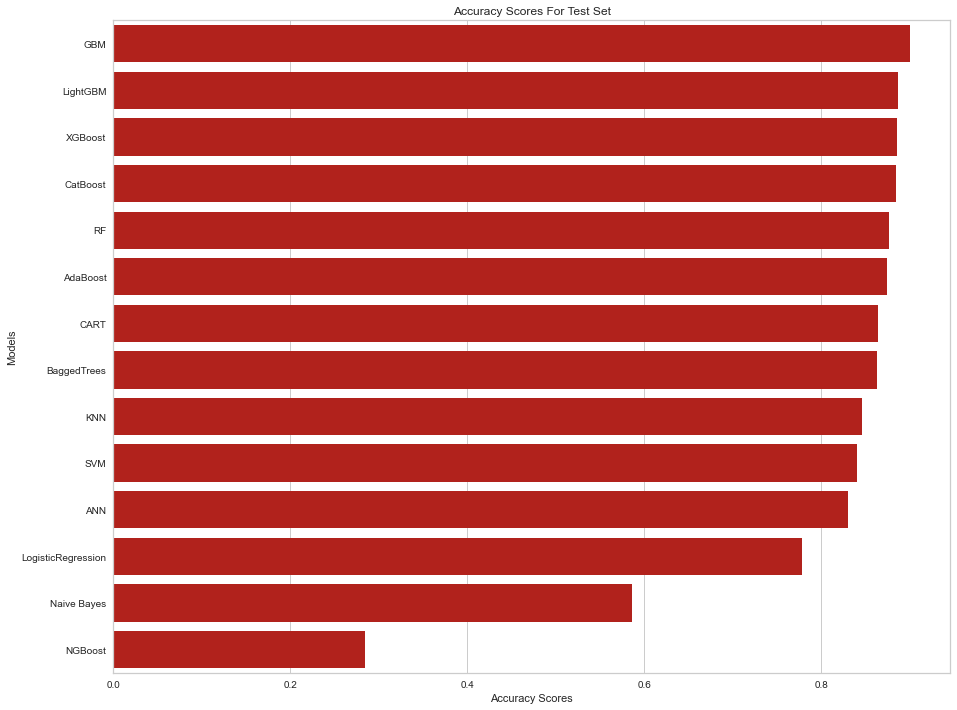

################ Accuracy scores (cross-validation=10) for test set for the models: ################

LogisticRegression: 0.791644

################ Train and test results for the model: ################

               models  accuracy_train  cross_val_score
0  LogisticRegression           0.797            0.792


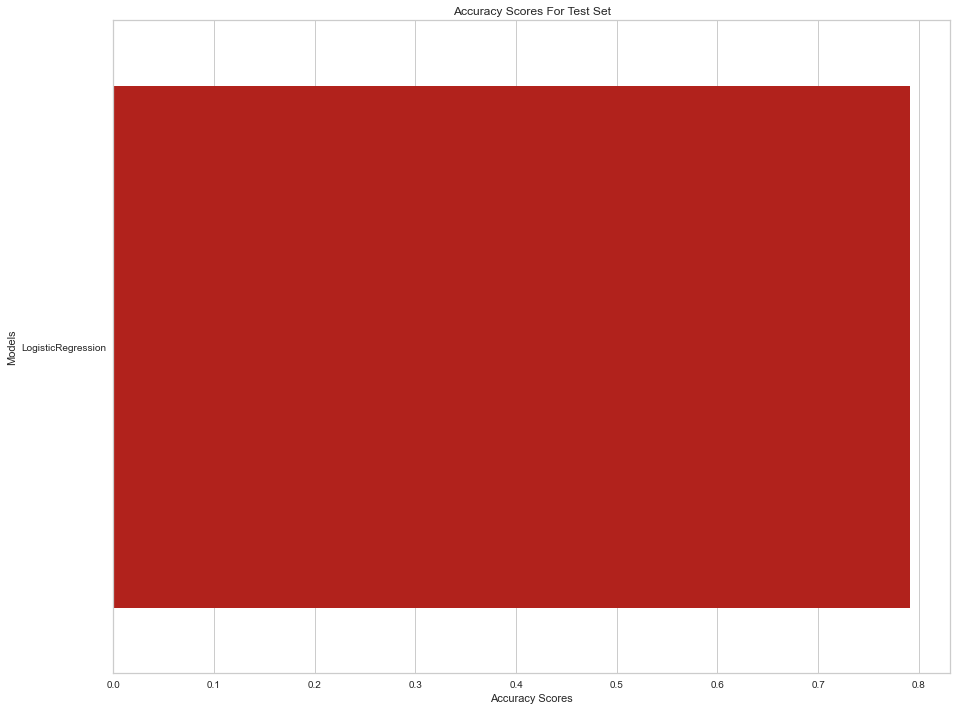

################ Accuracy scores (cross-validation=10) for test set for the models: ################

KNN: 0.820352

################ Train and test results for the model: ################

  models  accuracy_train  cross_val_score
0    KNN           0.858            0.820


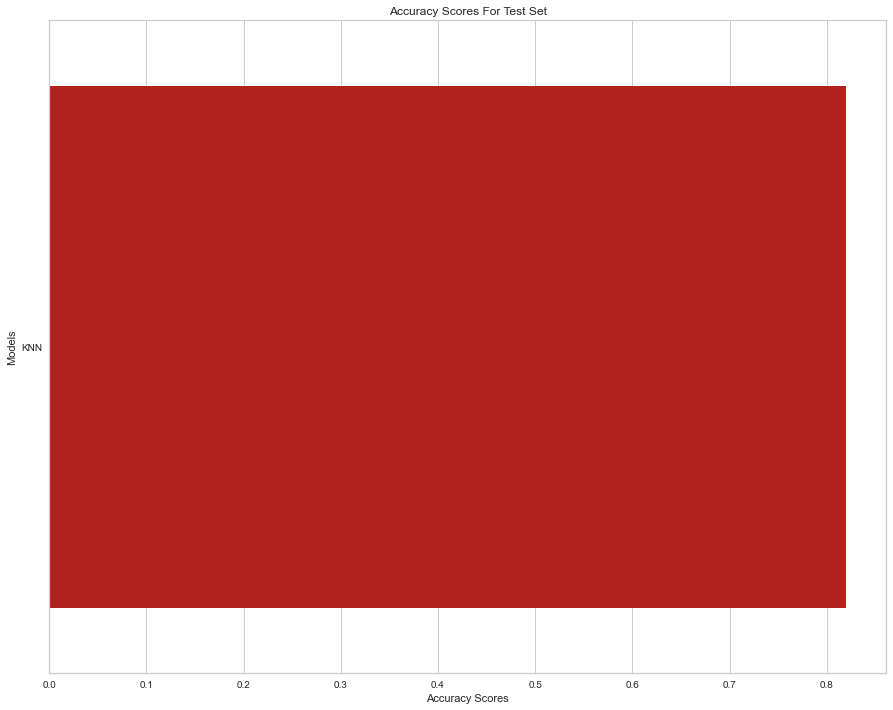

################ Accuracy scores (cross-validation=10) for test set for the models: ################

SVM: 0.837235

################ Train and test results for the model: ################

  models  accuracy_train  cross_val_score
0    SVM           0.896            0.837


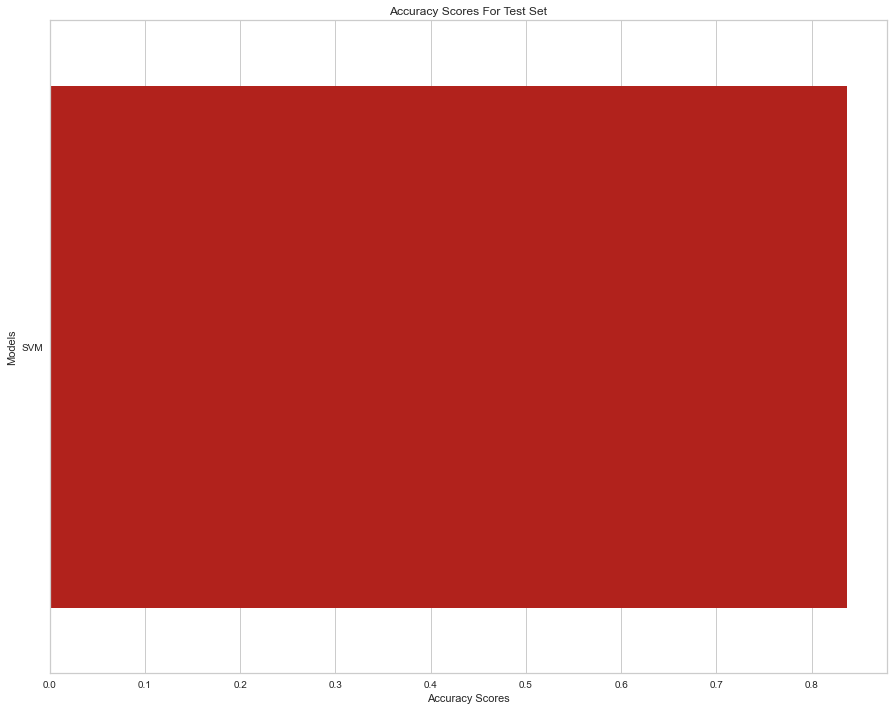

################ Accuracy scores (cross-validation=10) for test set for the models: ################

ANN: 0.841217

################ Train and test results for the model: ################

  models  accuracy_train  cross_val_score
0    ANN           0.895            0.841


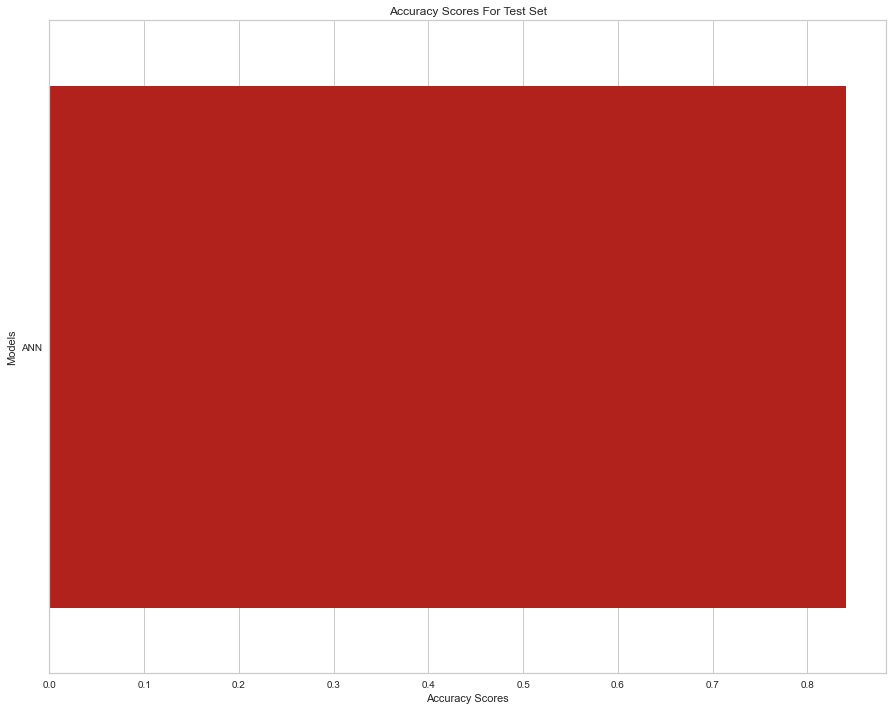

################ Accuracy scores (cross-validation=10) for test set for the models: ################

[iter 0] loss=0.6468 val_loss=0.0000 scale=4.0000 norm=8.0000
[iter 100] loss=0.2196 val_loss=0.0000 scale=2.0000 norm=2.7495
[iter 200] loss=0.1841 val_loss=0.0000 scale=0.5000 norm=0.6695
[iter 300] loss=0.1735 val_loss=0.0000 scale=1.0000 norm=1.3283
[iter 400] loss=0.1693 val_loss=0.0000 scale=0.2500 norm=0.3318
[iter 0] loss=0.6420 val_loss=0.0000 scale=4.0000 norm=8.0000
[iter 100] loss=0.2134 val_loss=0.0000 scale=4.0000 norm=5.4071
[iter 200] loss=0.1773 val_loss=0.0000 scale=0.5000 norm=0.6626
[iter 300] loss=0.1675 val_loss=0.0000 scale=2.0000 norm=2.6385
[iter 400] loss=0.1626 val_loss=0.0000 scale=1.0000 norm=1.3166
[iter 0] loss=0.6511 val_loss=0.0000 scale=4.0000 norm=8.0000
[iter 100] loss=0.2146 val_loss=0.0000 scale=2.0000 norm=2.7130
[iter 200] loss=0.1840 val_loss=0.0000 scale=1.0000 norm=1.3323
[iter 300] loss=0.1695 val_loss=0.0000 scale=2.0000 norm=2.6336
[iter 40

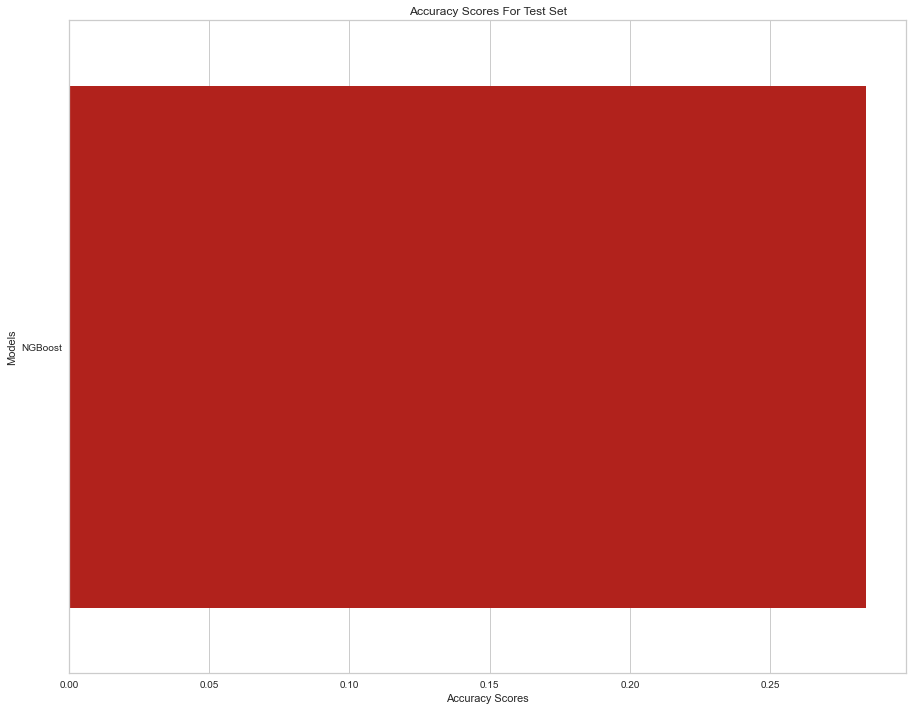

In [14]:
# See the results for base models
base_models = [('LogisticRegression', LogisticRegression()),
               ('Naive Bayes', GaussianNB()),
               ('KNN', KNeighborsClassifier()),
               ('SVM', SVC()),
               ('ANN', MLPClassifier()),
               ('CART', DecisionTreeClassifier()),
               ('BaggedTrees', BaggingClassifier()),
               ('RF', RandomForestClassifier()),
               ('AdaBoost', AdaBoostClassifier()),
               ('GBM', GradientBoostingClassifier()),
               ("XGBoost", XGBClassifier()),
               ("LightGBM", LGBMClassifier()),
               ("CatBoost", CatBoostClassifier(verbose=False)),
               ("NGBoost", NGBClassifier(verbose=False))]

evaluate_classification_model_cross_validation(base_models, X, y)
# LogisticRegression: 0.773462
# Naive Bayes: 0.585800
# KNN: 0.851538
# SVM: 0.847556
# ANN: 0.837218
# CART: 0.845147
# BaggedTrees: 0.881562
# RF: 0.880229
# AdaBoost: 0.864610
# GBM: 0.886791
# XGBoost: 0.877683
# LightGBM: 0.877700

# For some distance-based models, we need to scale the features in order to
# increase the speed and the performance/accuracy level of the model.
# We can also see the effect of scaling type by changing the sclaer function.
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

# LogisticRegression with make_pipeline
logreg = make_pipeline(MinMaxScaler(), LogisticRegression())
evaluate_classification_model_cross_validation([('LogisticRegression', logreg)], X, y) # 0.776 instead of 0.773462

# KNN with make_pipeline
knn = make_pipeline(RobustScaler(), KNeighborsClassifier())
evaluate_classification_model_cross_validation([('KNN', knn)], X, y) # 0.818 instead of 0.851538

# SVC with make_pipeline
svc = make_pipeline(RobustScaler(), SVC())
evaluate_classification_model_cross_validation([('SVM', svc)], X, y) # 0.852 instead of 0.847556

# ANN with make_pipeline
ann = make_pipeline(StandardScaler(), MLPClassifier())
evaluate_classification_model_cross_validation([('ANN', ann)], X, y) # 0.845 instead of 0.837218

# NGBClassifier with make_pipeline
ngb = make_pipeline(RobustScaler(), NGBClassifier())
evaluate_classification_model_cross_validation([('NGBoost', ngb)], X, y) #


# MODEL TUNING

'''
Models to be tuned:
    - LogisticRegression
    - RandomForestClassifier
    - LightGBMClassifier
    - XGBClassifier
'''

Fitting 10 folds for each of 16 candidates, totalling 160 fits


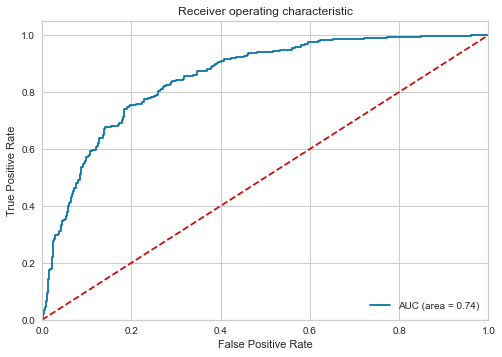

In [15]:
# LogisticRegression # 0.773462

logreg_model = LogisticRegression(random_state=12345)
logreg_params = {'penalty': ['l1', 'l2'],
                 'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25]}

logreg_cv_model = GridSearchCV(logreg_model, logreg_params, cv=10, n_jobs=-1, verbose=2).fit(X, y)
logreg_cv_model.best_params_ # {'C': 25, 'penalty': 'l2'}

# Final Model
logreg_tuned = LogisticRegression(**logreg_cv_model.best_params_).fit(X,y)
cross_val_score(logreg_tuned, X, y, cv=10).mean() # 0.7786739576213261

# Visualization of Results --> Feature Importances
confusion_matrix(y, logreg_tuned.predict(X))
plot_roc_auc_curve(logreg_tuned)


Fitting 10 folds for each of 192 candidates, totalling 1920 fits


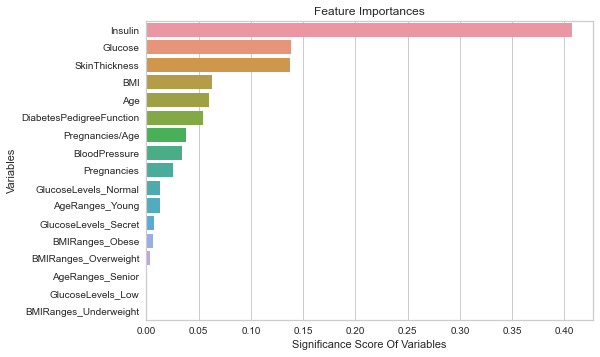

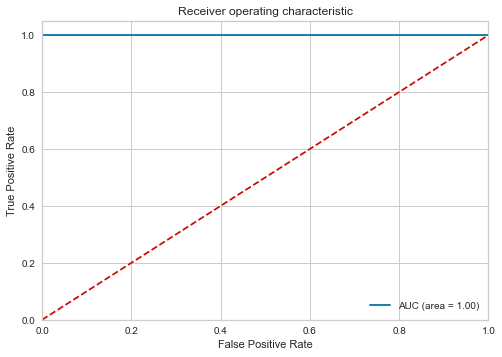

In [16]:
# RandomForestClassifier # 0.880229

rf_model = RandomForestClassifier(random_state=12345)
rf_params = {"n_estimators": [100, 200, 500, 1000],
             "max_features": [3, 5, 7],
             "min_samples_split": [2, 5, 10, 30],
            "max_depth": [3, 5, 8, None]}

rf_cv_model = GridSearchCV(rf_model, rf_params, cv=10, n_jobs=-1, verbose=2).fit(X, y)
rf_cv_model.best_params_ # {'max_depth': None, 'max_features': 5, 'min_samples_split': 2, 'n_estimators': 500}

# Final Model
rf_tuned = RandomForestClassifier(**rf_cv_model.best_params_).fit(X,y)
cross_val_score(rf_tuned, X, y, cv=10).mean() # 0.886790840738209

# Visualization of Results --> Feature Importances
plot_feature_importances(rf_tuned)
confusion_matrix(y, rf_tuned.predict(X))
plot_roc_auc_curve(rf_tuned)


Fitting 10 folds for each of 81 candidates, totalling 810 fits


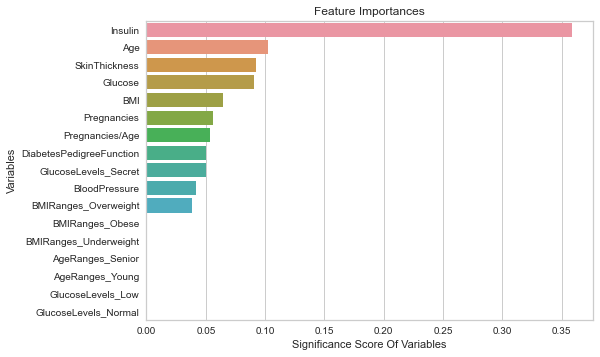

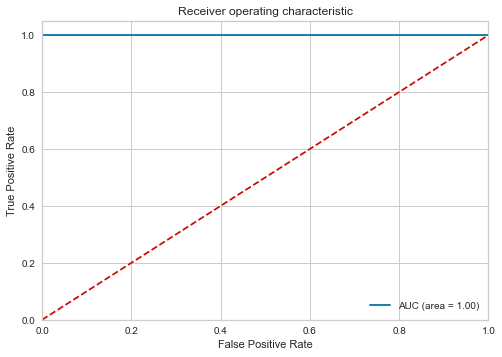

In [17]:
# XGBClassifier # 0.877683

xgb_model = XGBClassifier()
xgb_params = {"learning_rate": [0.1, 0.01, 1],
             "max_depth": [2, 5, 8],
             "n_estimators": [100, 500, 1000],
             "colsample_bytree": [0.3, 0.6, 1]}

xgb_cv_model = GridSearchCV(xgb_model, xgb_params, cv=10, n_jobs=-1, verbose=2).fit(X, y)
xgb_cv_model.best_params_ # {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}

# Final Model
xgb_tuned = XGBClassifier(**xgb_cv_model.best_params_).fit(X,y)
cross_val_score(xgb_tuned, X, y, cv=10).mean() # 0.895933014354067

# Visualization of Results --> Feature Importances
plot_feature_importances(xgb_tuned)
confusion_matrix(y, xgb_tuned.predict(X))
plot_roc_auc_curve(xgb_tuned)

Fitting 10 folds for each of 81 candidates, totalling 810 fits


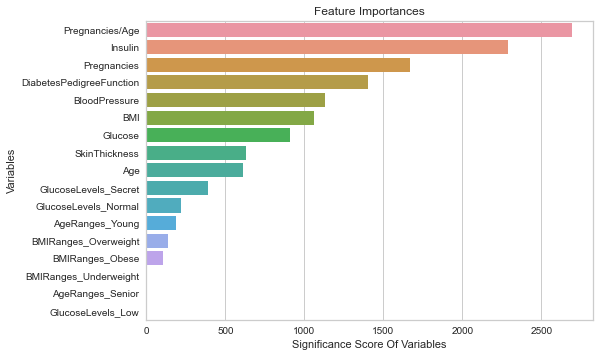

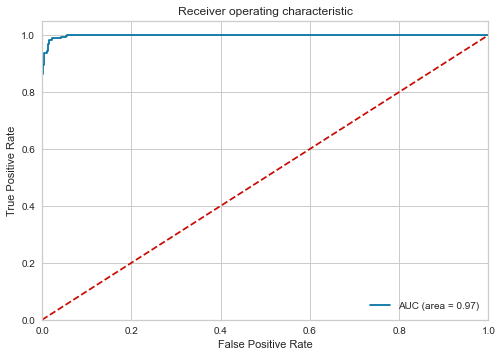

In [18]:
# LightGBMClassifier # 0.877700

lgbm_model = LGBMClassifier()
lgbm_params = {"learning_rate": [0.01, 0.05, 0.1],
              "n_estimators": [200, 500, 1000],
              "max_depth":[5,8,10],
              "colsample_bytree": [1,0.5,0.3]}

lgbm_cv_model = GridSearchCV(lgbm_model, lgbm_params, cv=10, n_jobs=-1, verbose=2).fit(X, y)
lgbm_cv_model.best_params_ # {'colsample_bytree': 0.05, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 800}

# Final Model
lgbm_tuned = LGBMClassifier(**lgbm_cv_model.best_params_).fit(X, y)
cross_val_score(lgbm_tuned, X, y, cv=10).mean() # 0.8971804511278195

# Visualization of Results --> Feature Importances
plot_feature_importances(lgbm_tuned)
confusion_matrix(y, lgbm_tuned.predict(X))
plot_roc_auc_curve(lgbm_tuned)

In [20]:
# Comparison of tuned models

tuned_models = [('LogisticRegression', logreg_tuned),
                ('RF', rf_tuned),
                ('XGBoost', xgb_tuned),
                ('LightGBM', lgbm_tuned)]

# evaluate each model in turn
results = []
names = []

for name, model in tuned_models:
    kfold = KFold(n_splits=10, random_state=12345)
    cv_results = cross_val_score(model, X, y, cv=10, scoring="accuracy")
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# LogisticRegression: 0.778674 (0.038794)
# RF: 0.884176 (0.033919)
# XGBoost: 0.895933 (0.027015)
# LightGBM: 0.897180 (0.029169)



ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.

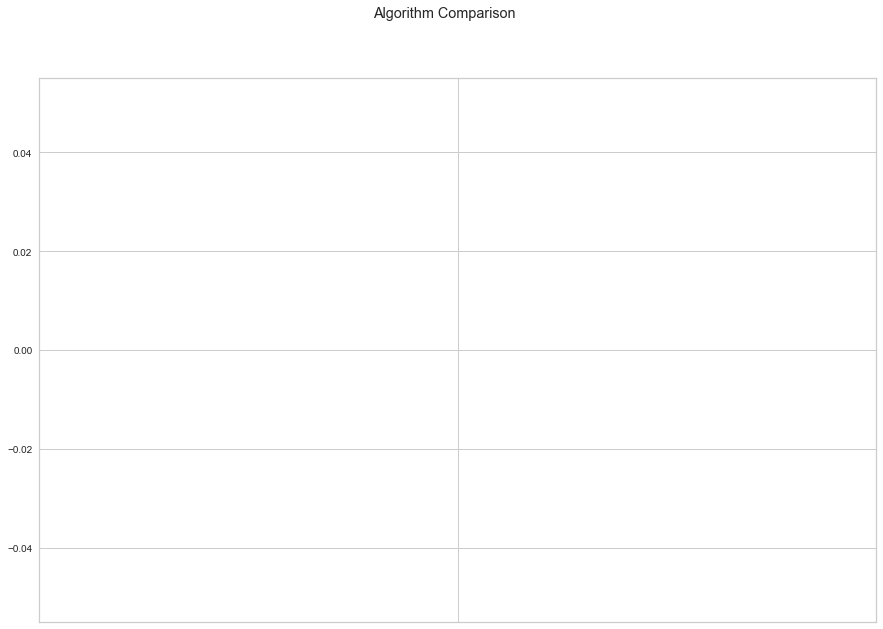

################ Accuracy scores (cross-validation=10) for test set for the models: ################

LogisticRegression: 0.783852
RF: 0.884159
XGBoost: 0.902375
LightGBM: 0.897180

################ Train and test results for the model: ################

               models  accuracy_train  cross_val_score
0  LogisticRegression           0.784            0.784
1                  RF           1.000            0.884
2             XGBoost           1.000            0.902
3            LightGBM           0.978            0.897


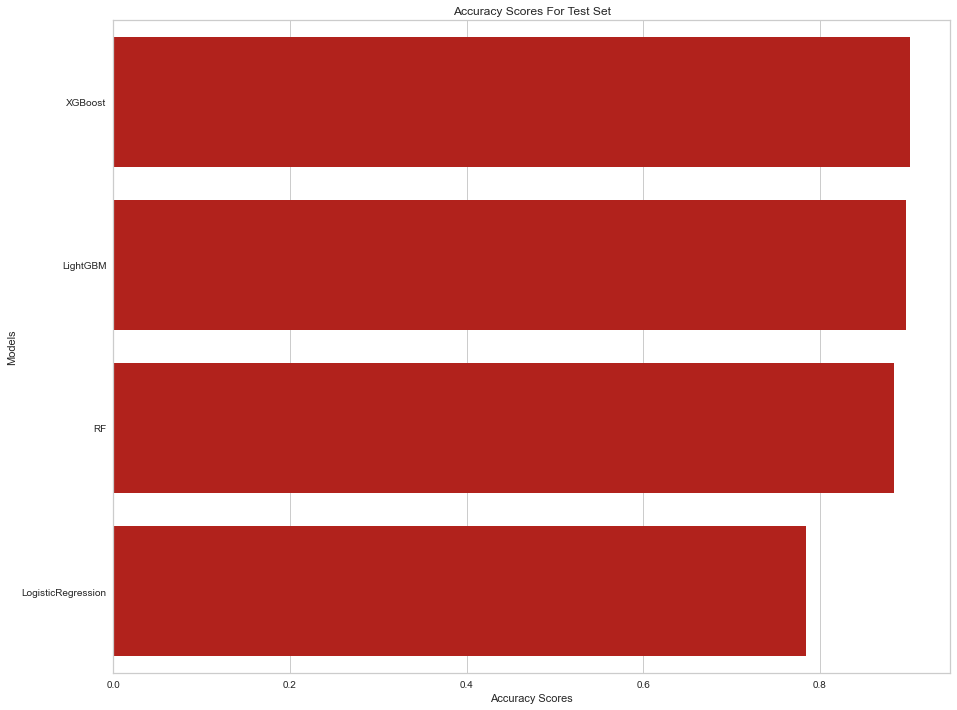

In [21]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


evaluate_classification_model_cross_validation(tuned_models, X, y)